[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/KaggleProj)

# Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.axes_style("whitegrid")

import glob

from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler, binarize, label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_validate

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

# Paths and Consts

In [2]:
r_hand_path = 'data\\HandRight.csv'
train_path = 'data\\Training\\*\\*'
test_path = 'data\\Validation\\*\\*'
START_DELAY = 7
CV_SPLIT = 10
CORES = 3
CLASS_NAMES = {0: 'Alone', 1: 'Spontan', 2: 'Sync'}
model_dict = {}

# Funcs

### plot funcs

In [3]:
def plot_corr(df):
    # Sample dataframe with date index and five variables 
    np.random.seed(123)
    df = df.iloc[:, :-1]

    # Compute correlations
    corr = df.corr()

    # Exclude duplicate correlations by masking uper right values
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap
    cmap = sns.diverging_palette(10, 250, as_cmap=True)

    # Draw correlation plot
    sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    plt.show()

### data funcs

In [4]:
def pars_data(path):
    pars_df = pd.DataFrame()

    r_hand_df = pd.read_csv(r_hand_path)
    r_hand_df = prepare_data(r_hand_df)
#     print(r_hand_df.shape)

    for name in glob.glob(path):
#         print(name)
        df = pd.read_csv(name)
        print('before', df.shape[0])

        df.dropna(inplace=True)
        if 'Alone' in name[-11:]: #add r hand
            df = mod_df(df, r_hand_df.copy()) 
            df['value'] = 0

        else:
            df  = mod_df(df)
            if 'Spontan' in name[-11:]:
                df['value'] = 1
            elif 'Sync' in name[-11:]:
                df['value'] = 2
            else:
                print('ERORR')

        print('after', df.shape)
        pars_df = pars_df.append(df, ignore_index=True)
    
    return pars_df

In [5]:
def prepare_data(df):
    df.rename(str.strip, axis='columns', inplace=True)
    df.dropna(inplace=True)
    df = df[df['Time']>=df['Time'][0]+START_DELAY]
    df.drop('# hands', axis=1, inplace=True)
    return df

In [6]:
def add_suffix_on_split(split_df1, split_df2):
    if split_df1['Hand Type'][0] == 'left':
        split_df1 = split_df1.add_suffix(' Left')
        split_df2 = split_df2.add_suffix(' Right')
    else:
        split_df1 = split_df1.add_suffix(' Right')
        split_df2 = split_df2.add_suffix(' Left')
    return split_df1, split_df2

In [7]:
def combine_hands(df, split_df2=None):
    if split_df2 is None:
        split1 = np.arange(0, df.shape[0], 2)
        split2 = np.arange(1, df.shape[0], 2)
        
        if df['Hand Type'].values[0] == 'left':
            split_df1 = df.iloc[split1, :]
            split_df2 = df.iloc[split2, :]
        else:
            split_df1 = df.iloc[split2, :]
            split_df2 = df.iloc[split1, :]
    else:
        split_df1 = df.copy()

    if split_df1.shape[0] > split_df2.shape[0]:
        split_df1 = split_df1.iloc[np.arange(split_df2.shape[0]), :]
    else:
        split_df2 = split_df2.iloc[np.arange(split_df1.shape[0]), :]

    split_df1.set_index(np.arange(split_df1.shape[0]), inplace=True)
    split_df2.set_index(np.arange(split_df1.shape[0]), inplace=True)
    
    split_df1 = split_df1.add_suffix(' Left')
    split_df2 = split_df2.add_suffix(' Right')

    df = pd.concat([split_df1, split_df2], axis=1, sort=False)
    df.drop(['Time Left', 'Time Right'], axis=1, inplace=True)
    
    return df

In [8]:
def cut_df(df):
    start_time = df.iloc[0, 0]
    end_time = df.iloc[len(df)-1, 0]
    total_time = (end_time - start_time)
    start_frame = df.iloc[0, 1]
    end_frame = df.iloc[len(df)-1, 1]
    total_frame = (end_frame - start_frame)
#     jump = int(total_time)//2
    jump = 4
    if jump%2 == 1:
        jump += 1
    
    tmp1 = np.arange(0, df.shape[0], jump)
    tmp2 = np.arange(1, df.shape[0], jump)
    df['tmp'] = np.arange(df.shape[0])
    df_cut = df[df['tmp'].isin(np.append(tmp1, tmp2))]
    df_cut.drop('tmp', axis=1, inplace=True)
    
    return df_cut

In [9]:
def mod_df(df, r_hand_df=None):
    df = prepare_data(df)    
    df_cut = cut_df(df)
    df_cut = combine_hands(df_cut, r_hand_df)
    
    return df_cut

### model funcs

In [10]:
def evaluate(true, pred, plot=False):
    print("confusion_matrix:\n", confusion_matrix(true, pred))
    print(classification_report(true, pred))
    print('f1 score {}'.format(f1_score(true, pred, average='weighted')))
    print('accuracy score {}'.format(accuracy_score(true, pred)))
    if plot:
        plot_scores(true, pred)

In [11]:
def score_models(model, model_scores=None, true=None, pred=None):
    if model_scores is None:
        model_scores = [f1_score(true, pred, average='micro'), accuracy_score(true, pred)]
    else:
        print("Accuracy: {:.2f} (+/- {:.2f})".format(model_scores['test_score'].mean(), model_scores['test_score'].std() * 2))
        print('Train time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['fit_time'].mean(), model_scores['fit_time'].std() * 2, model_scores['fit_time'].sum()))
        print('Test time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['score_time'].mean(), model_scores['score_time'].std() * 2, model_scores['score_time'].sum()))
    model_dict.update({model: model_scores})

In [12]:
def find_best_model(estimator='combined'):
    max_score = 0
    best_key = None
    for key in model_dict:
        if type(model_dict[key]) is list:
            model_score = model_dict[key][0] * model_dict[key][1]
        else:
            model_score = model_dict[key]['test_score'].mean()
#         model_score = model_dict[key]['test_score']
#         if estimator == 'combined':
#             model_score = model_dict[key][0] * model_dict[key][1]
#         elif estimator == 'f1':
#             model_score = model_dict[key][0]
#         elif estimator == 'accuracy':
#             model_score = model_dict[key][1]
            
        if max_score < model_score:
            max_score = model_score
            best_key = key
    print('the best model is {}'.format(best_key).split('(')[0], end = ' ')
    print('with the score of {}'.format(max_score))
    return best_key, max_score

In [13]:
def plot_scores(true, pred):
    from sklearn.metrics import precision_score, recall_score, f1_score
    labels = np.unique(true)

    ytest = label_binarize(true, classes=labels)
    ypreds = label_binarize(pred, classes=labels)

    n_classes = len(labels)
    f1_scores = dict()
    accuracy_scores = dict()
    for i in range(n_classes):
        f1_scores[i] = f1_score(ytest[:, i], ypreds[:, i], average='weighted')
        accuracy_scores[i] = accuracy_score(ytest[:, i], ypreds[:, i])
        plt.scatter(f1_scores[i], accuracy_scores[i], lw=2, label=CLASS_NAMES[i])

    x = list(f1_scores.values())
    y = list(accuracy_scores.values())
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--")
    print("y=%.6fx+(%.6f)"%(z[0],z[1]))
    
    plt.xlabel("f1_scores")
    plt.ylabel("accuracy_scores")
    plt.legend(loc="best")
    plt.title("f1_scores vs. accuracy_scores")
    plt.show()
    print(labels)
    print(accuracy_scores)
    print(f1_scores)
    return f1_scores

In [14]:
def cv_mean_model(model_estimators, true, X_pred):
    size = len(true)
    split = size//CV_SPLIT
    X_cv_split = np.arange(0, size+1, split)

    pred_2d = np.zeros((CV_SPLIT, size))
    for idx, estimator in enumerate(model_estimators):
        pred = estimator.predict(X_pred)
        pred_2d[idx] = pred
        
    predictions = pred_2d[0].copy()
    tmp = np.rot90(pred_2d) 
    
    for idx in range(size):
        u, indices = np.unique(tmp[idx], return_index=True)
        predictions[idx] = u[0]
    evaluate(true, np.flip(predictions), plot=True)

## data mod

In [15]:
train_df = pars_data(train_path)
test_df = pars_data(test_path)

C:\Users\mthee\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\mthee\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


before 9054
after (2052, 41)
before 9054
after (2052, 41)
before 4476
after (2027, 41)
before 9054
after (2052, 41)
before 9052
after (2052, 41)
before 4526
after (2052, 41)
before 9054
after (2052, 41)
before 4496
after (2036, 41)
before 9052
after (2052, 41)
before 8998
after (2038, 41)
before 4575
after (2076, 41)
before 9054
after (2052, 41)
before 9011
after (2041, 41)
before 4367
after (1991, 41)
before 4500
after (2039, 41)
before 9054
after (2052, 41)
before 9050
after (2051, 41)
before 4482
after (2030, 41)
before 9039
after (2048, 41)
before 8807
after (1990, 41)
before 8805
after (1990, 41)
before 4527
after (2052, 41)
before 8937
after (2037, 41)
before 9050
after (2051, 41)
before 9054
after (2052, 41)
before 8746
after (1975, 41)
before 4931
after (2150, 41)
before 8826
after (2012, 41)
before 8395
after (1887, 41)
before 9054
after (2052, 41)
before 9046
after (2050, 41)
before 4526
after (2052, 41)
before 8980
after (2034, 41)
before 4477
after (2028, 41)
before 8742
af

In [16]:
train_df.isnull().sum().unique()

array([0], dtype=int64)

In [17]:
train_df.isna().sum().unique()

array([0], dtype=int64)

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89435 entries, 0 to 89434
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Frame ID Left         89435 non-null  int64  
 1   Hand Type Left        89435 non-null  object 
 2   Position X Left       89435 non-null  float64
 3   Position Y Left       89435 non-null  float64
 4   Position Z Left       89435 non-null  float64
 5   Velocity X Left       89435 non-null  float64
 6   Velocity Y Left       89435 non-null  float64
 7   Velocity Z Left       89435 non-null  float64
 8   Pitch Left            89435 non-null  float64
 9   Roll Left             89435 non-null  float64
 10  Yaw Left              89435 non-null  float64
 11  Wrist Pos X Left      89435 non-null  float64
 12  Wrist Pos Y Left      89435 non-null  float64
 13  Wrist Pos Z Left      89435 non-null  float64
 14  Elbow pos X Left      89435 non-null  float64
 15  Elbow Pos Y Left   

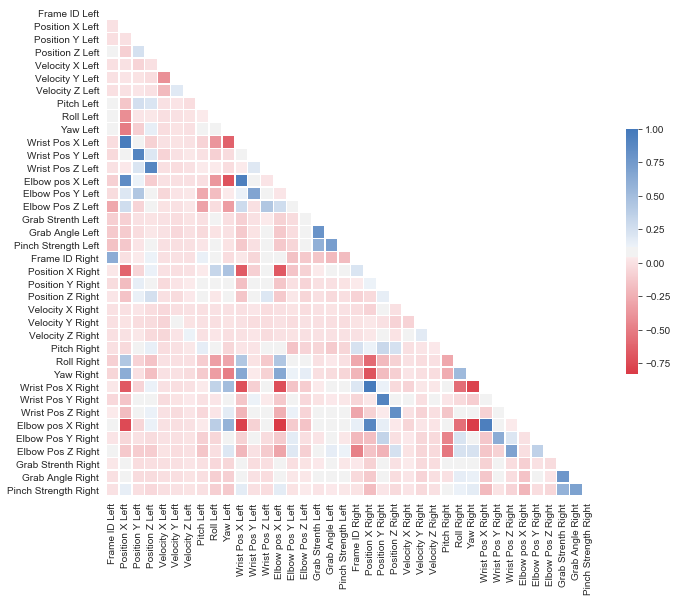

In [19]:
plot_corr(train_df)

In [20]:
train_df.drop(['Hand Type Left', 'Hand Type Right'], axis=1, inplace=True)
test_df.drop(['Hand Type Left', 'Hand Type Right'], axis=1, inplace=True)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89435 entries, 0 to 89434
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Frame ID Left         89435 non-null  int64  
 1   Position X Left       89435 non-null  float64
 2   Position Y Left       89435 non-null  float64
 3   Position Z Left       89435 non-null  float64
 4   Velocity X Left       89435 non-null  float64
 5   Velocity Y Left       89435 non-null  float64
 6   Velocity Z Left       89435 non-null  float64
 7   Pitch Left            89435 non-null  float64
 8   Roll Left             89435 non-null  float64
 9   Yaw Left              89435 non-null  float64
 10  Wrist Pos X Left      89435 non-null  float64
 11  Wrist Pos Y Left      89435 non-null  float64
 12  Wrist Pos Z Left      89435 non-null  float64
 13  Elbow pos X Left      89435 non-null  float64
 14  Elbow Pos Y Left      89435 non-null  float64
 15  Elbow Pos Z Left   

In [22]:
train_df = train_df.sample(frac=1, random_state=0).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=0).reset_index(drop=True)

In [23]:
X = train_df.drop('value', axis=1)
y = train_df['value']
X_val = test_df.drop('value', axis=1)
y_val = test_df['value']

In [24]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
X_train_minmax = mm_scaler.fit_transform(X)
tmp = mm_scaler.transform(X)
tmpdf = pd.DataFrame(tmp)
for i in range(tmpdf.shape[1]):
    tmpdf.rename(columns={i: X.columns[i]}, inplace=True)
X = tmpdf

tmp = mm_scaler.transform(X_val)
tmpdf = pd.DataFrame(tmp)
for i in range(tmpdf.shape[1]):
    tmpdf.rename(columns={i: X_val.columns[i]}, inplace=True)
X_val = tmpdf
X

,Frame ID Left,Position X Left,Position Y Left,Position Z Left,Velocity X Left,Velocity Y Left,Velocity Z Left,Pitch Left,Roll Left,Yaw Left,...,Yaw Right,Wrist Pos X Right,Wrist Pos Y Right,Wrist Pos Z Right,Elbow pos X Right,Elbow Pos Y Right,Elbow Pos Z Right,Grab Strenth Right,Grab Angle Right,Pinch Strength Right
0,0.075106,0.233245,0.123342,0.523156,0.602824,0.559690,0.467394,0.858392,0.503395,0.771788,...,0.217841,0.833065,0.363423,0.636519,0.859213,0.403666,0.346882,0.000000,0.056885,0.000000
1,0.453635,0.281778,0.149922,0.412883,0.624231,0.535391,0.472720,0.587423,0.851471,0.598373,...,0.475591,0.642656,0.225611,0.754401,0.617425,0.265776,0.727069,0.000000,0.066201,0.000000
2,0.116702,0.242572,0.134606,0.292170,0.615867,0.561629,0.473024,0.642017,0.626587,0.626094,...,0.273829,0.882866,0.404140,0.387227,0.823856,0.358951,0.305961,0.000000,0.259749,0.000000
3,0.280442,0.289534,0.195242,0.326139,0.620967,0.557362,0.483170,0.711429,0.548662,0.734505,...,0.443919,0.870881,0.320462,0.492855,0.831710,0.336663,0.445974,0.625489,0.657359,0.263364
4,0.981901,0.287202,0.088652,0.332324,0.682822,0.595763,0.468700,0.710533,0.538214,0.739922,...,0.437457,0.676010,0.402758,0.681257,0.639352,0.404296,0.687680,1.000000,1.000000,0.486827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89430,0.363310,0.304141,0.135911,0.406017,0.610896,0.564320,0.474787,0.761231,0.644488,0.764150,...,0.495721,0.659265,0.296567,0.633895,0.637563,0.516483,0.755545,0.000000,0.082142,0.000000
89431,0.275574,0.455616,0.124263,0.299236,0.623570,0.548894,0.470851,0.546822,0.485376,0.428540,...,0.730856,0.370987,0.357663,0.477240,0.142136,0.407182,0.359176,0.000000,0.000000,0.000000
89432,0.166667,0.443012,0.080578,0.372196,0.585301,0.536267,0.446455,0.584054,0.316850,0.373438,...,0.754259,0.386816,0.303262,0.321557,0.163040,0.339280,0.246525,0.000000,0.325843,0.603101
89433,0.202297,0.380220,0.093531,0.359413,0.644813,0.554926,0.489932,0.755846,0.603233,0.754369,...,0.486399,0.625855,0.569218,0.592686,0.626911,0.567007,0.641660,0.000000,0.083019,0.000000


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

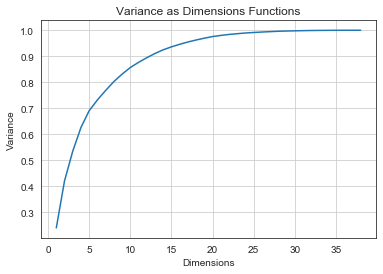

In [26]:
pca = PCA(random_state=0)
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(1, len(cumsum)+1)
plt.plot(x, cumsum)
plt.grid(True)
plt.title('Variance as Dimensions Functions')
plt.xlabel('Dimensions')
plt.ylabel('Variance')
plt.show()

In [27]:
pca = PCA(random_state=0, n_components=0.90)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)
d = len(pca.singular_values_)
print('the number of vectors after pca is {}'.format(d))

the number of vectors after pca is 13


---
# Models

## Run The Models

### Naive Bayes

Accuracy: 0.76 (+/- 0.01)
Train time: 0.06 seconds (+/- 0.02) for a total of 0.58 seconds
Test time: 0.01 seconds (+/- 0.00) for a total of 0.05 seconds
confusion_matrix:
 [[18325  1572   123]
 [  520 12959  7850]
 [  114  4640 16501]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     20020
           1       0.68      0.61      0.64     21329
           2       0.67      0.78      0.72     21255

    accuracy                           0.76     62604
   macro avg       0.77      0.77      0.77     62604
weighted avg       0.77      0.76      0.76     62604

f1 score 0.7637332266881462
accuracy score 0.7632898856303112
y=0.995926x+(0.003589)


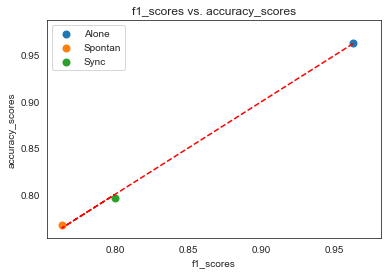

[0 1 2]
{0: 0.962797904287266, 1: 0.7670755862245224, 2: 0.796706280748834}
{0: 0.9625204633365096, 1: 0.7638369820434091, 2: 0.7997446784651505}


In [28]:
gnb = GaussianNB()
gnb_scores = cross_validate(gnb, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True)
score_models(gnb, gnb_scores)
cv_mean_model(gnb_scores['estimator'], y_train, X_train_pca)

confusion_matrix:
 [[7923  665   53]
 [ 224 5523 3429]
 [  47 1934 7033]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      8641
           1       0.68      0.60      0.64      9176
           2       0.67      0.78      0.72      9014

    accuracy                           0.76     26831
   macro avg       0.77      0.77      0.77     26831
weighted avg       0.77      0.76      0.76     26831

f1 score 0.7634952197738288
accuracy score 0.763258916924453
y=0.994714x+(0.004664)


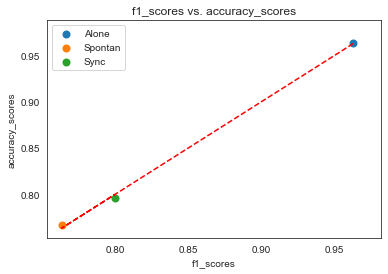

[0 1 2]
{0: 0.9631396518951959, 1: 0.7669859490887406, 2: 0.7963922328649696}
{0: 0.9628739994973108, 1: 0.7632638770697474, 2: 0.7997400551499261}


In [29]:
cv_mean_model(gnb_scores['estimator'], y_test, X_test_pca)

### Decision Tree

Accuracy: 0.94 (+/- 0.01)
Train time: 1.33 seconds (+/- 0.09) for a total of 13.30 seconds
Test time: 0.00 seconds (+/- 0.00) for a total of 0.02 seconds
confusion_matrix:
 [[20020     0     0]
 [  192 21120    17]
 [   76  2495 18684]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     20020
           1       0.89      0.99      0.94     21329
           2       1.00      0.88      0.94     21255

    accuracy                           0.96     62604
   macro avg       0.96      0.96      0.96     62604
weighted avg       0.96      0.96      0.96     62604

f1 score 0.9553853624771982
accuracy score 0.9555938917641045
y=0.997344x+(0.002647)


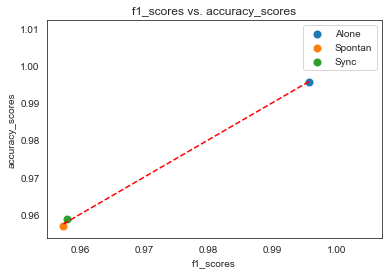

[0 1 2]
{0: 0.9957191233786978, 1: 0.9568078717014887, 2: 0.9586607884480225}
{0: 0.9957265981088878, 1: 0.9572912409401534, 2: 0.957958805831293}


In [30]:
dtc = DecisionTreeClassifier(max_depth=15, random_state=0)
dtc_scores = cross_validate(dtc, X_train_pca, y_train, cv=CV_SPLIT, n_jobs=CORES, return_estimator=True)
score_models(dtc, dtc_scores)
cv_mean_model(dtc_scores['estimator'], y_train, X_train_pca)

confusion_matrix:
 [[8638    2    1]
 [ 271 8874   31]
 [ 127 2175 6712]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8641
           1       0.80      0.97      0.88      9176
           2       1.00      0.74      0.85      9014

    accuracy                           0.90     26831
   macro avg       0.92      0.90      0.90     26831
weighted avg       0.92      0.90      0.90     26831

f1 score 0.9010200319435823
accuracy score 0.9028362714770228
y=0.985930x+(0.013778)


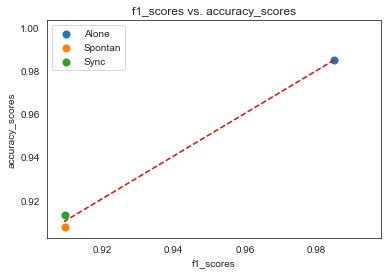

[0 1 2]
{0: 0.9850546010212068, 1: 0.907606872647311, 2: 0.9130110692855279}
{0: 0.9851395553373163, 1: 0.9092985409121382, 2: 0.9093503282290627}


In [31]:
cv_mean_model(dtc_scores['estimator'], y_test, X_test_pca)

### Random Forest

Accuracy: 0.99 (+/- 0.00)
Train time: 10.20 seconds (+/- 2.75) for a total of 101.99 seconds
Test time: 0.11 seconds (+/- 0.00) for a total of 1.05 seconds
confusion_matrix:
 [[20020     0     0]
 [   50 21278     1]
 [    7   471 20777]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20020
           1       0.98      1.00      0.99     21329
           2       1.00      0.98      0.99     21255

    accuracy                           0.99     62604
   macro avg       0.99      0.99      0.99     62604
weighted avg       0.99      0.99      0.99     62604

f1 score 0.9915479410327539
accuracy score 0.9915500606989969
y=1.000193x+(-0.000191)


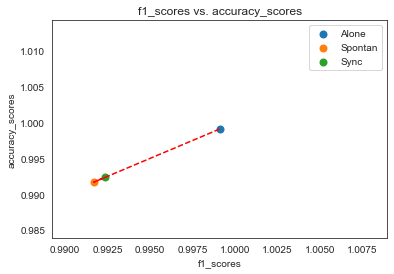

[0 1 2]
{0: 0.9990895150469619, 1: 0.9916618746405981, 2: 0.9923487317104338}
{0: 0.9990898573160405, 1: 0.9916812020497631, 2: 0.9923272571631733}


In [32]:
rf = RandomForestClassifier(max_depth=20, random_state=0, n_jobs=CORES)
rf_scores = cross_validate(rf, X_train_pca, y_train, cv=CV_SPLIT, n_jobs=CORES, return_estimator=True)
score_models(rf, rf_scores)
cv_mean_model(rf_scores['estimator'], y_train, X_train_pca)

confusion_matrix:
 [[8639    2    0]
 [  32 9091   53]
 [   8  380 8626]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8641
           1       0.96      0.99      0.97      9176
           2       0.99      0.96      0.98      9014

    accuracy                           0.98     26831
   macro avg       0.98      0.98      0.98     26831
weighted avg       0.98      0.98      0.98     26831

f1 score 0.9822813085217869
accuracy score 0.982296597219634
y=0.999854x+(0.000149)


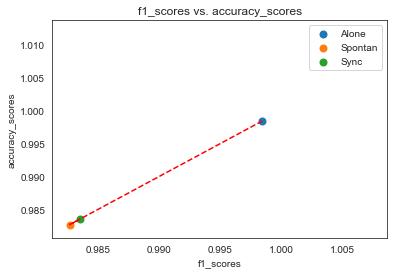

[0 1 2]
{0: 0.9984346464909992, 1: 0.982594759792777, 2: 0.9835637881554918}
{0: 0.9984355452960364, 1: 0.9826595353373834, 2: 0.9834847261457939}


In [33]:
cv_mean_model(rf_scores['estimator'], y_test, X_test_pca)

## Find Best Model

In [34]:
best_model, best_model_score = find_best_model()
best_model

the best model is RandomForestClassifier with the score of 0.9862628432106456


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## Improve The Model

### Ada Boost

#### find best estimator

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor

max_estimators = 20
abr = AdaBoostRegressor(n_estimators=max_estimators, learning_rate=2, random_state=0)
abr.fit(X_train_pca, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in abr.staged_predict(X_test_pca)]
bst_n_estimators = np.argmin(errors)
min_error = np.min(errors)
max_error = np.max(errors)

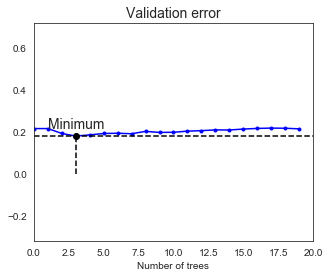

3

In [36]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot(errors, 'b.-')
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], 'k--')
plt.plot([0, 120], [min_error, min_error], 'k--')
plt.plot(bst_n_estimators, min_error, 'ko')
plt.text(bst_n_estimators, min_error*1.2, 'Minimum', ha='center', fontsize=14)
plt.axis([0, max_estimators, min_error-.5, max_error+.5])
plt.xlabel("Number of trees")
plt.title('Validation error', fontsize=14)
plt.show()
bst_n_estimators

confusion_matrix:
 [[20020     0     0]
 [   31 21298     0]
 [    5   505 20745]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20020
           1       0.98      1.00      0.99     21329
           2       1.00      0.98      0.99     21255

    accuracy                           0.99     62604
   macro avg       0.99      0.99      0.99     62604
weighted avg       0.99      0.99      0.99     62604

f1 score 0.9913562221617164
accuracy score 0.991358379656252
y=1.000056x+(-0.000055)


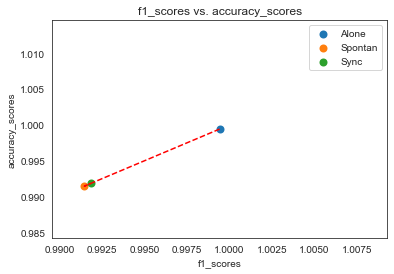

[0 1 2]
{0: 0.9994249568717654, 1: 0.9914382467573957, 2: 0.9918535556833429}
{0: 0.9994250935654191, 1: 0.9914605688975257, 2: 0.9918290607965368}


In [37]:
adb = AdaBoostClassifier(best_model, n_estimators=bst_n_estimators, random_state=0)
adb_scores = cross_validate(adb, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True, n_jobs=CORES)
cv_mean_model(adb_scores['estimator'], y_train, X_train_pca)

confusion_matrix:
 [[8640    1    0]
 [  17 9089   70]
 [   8  412 8594]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8641
           1       0.96      0.99      0.97      9176
           2       0.99      0.95      0.97      9014

    accuracy                           0.98     26831
   macro avg       0.98      0.98      0.98     26831
weighted avg       0.98      0.98      0.98     26831

f1 score 0.9810491889529951
accuracy score 0.9810666766054191
y=0.999602x+(0.000398)


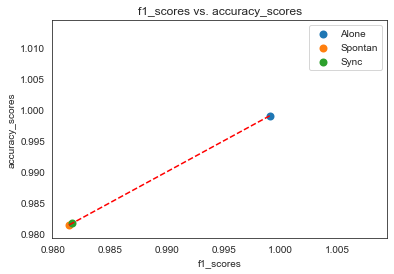

[0 1 2]
{0: 0.9990309716372853, 1: 0.9813648391785621, 2: 0.9817375423949909}
{0: 0.9990313237161218, 1: 0.9814406390295828, 2: 0.9816455719770997}


In [38]:
cv_mean_model(adb_scores['estimator'], y_test, X_test_pca)

# Final Run On Validate

confusion_matrix:
 [[8258   14   11]
 [  20 6732 1383]
 [   1 1520 6587]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8283
           1       0.81      0.83      0.82      8135
           2       0.83      0.81      0.82      8108

    accuracy                           0.88     24526
   macro avg       0.88      0.88      0.88     24526
weighted avg       0.88      0.88      0.88     24526

f1 score 0.8797691801021686
accuracy score 0.8797602544238767
y=1.000003x+(-0.000002)


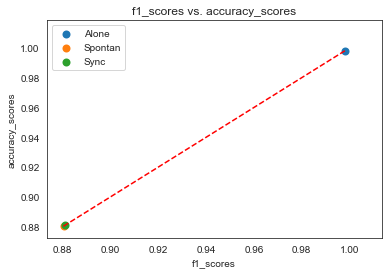

[0 1 2]
{0: 0.998124439370464, 1: 0.8802495311098426, 2: 0.8811465383674468}
{0: 0.9981243283354737, 1: 0.8804875465179611, 2: 0.8809064075921279}


In [39]:
adb.fit(X_train_pca, y_train)
predictions = adb.predict(X_val_pca)
evaluate(y_val, predictions, plot=True)

In [40]:
# from sklearn.ensemble import VotingClassifier
# vc = VotingClassifier(estimators=[('rf', rf), ('dtc', dtc), ('adb', adb), ('gnb', gnb)], voting='hard', n_jobs=1)
# vc.fit(X_train_pca, y_train)
# predictions = vc.predict(X_val_pca)
# evaluate(y_val, predictions, plot=True)

In [41]:
# best_model.fit(X, y)
# predictions = best_model.predict(X_val_pca)
# evaluate(y_val, predictions, plot=True)

In [42]:
# rf = RandomForestClassifier(random_state=0)
# rf.fit(X_train_pca,y_train)
# predictions = rnf.predict(X_test_pca)
# evaluate('rnf', y_test, predictions)
# plot_scores(y_test, predictions)

In [43]:
# predictions = rnf.predict(X_val_pca)
# evaluate('fsdfds', y_val, predictions)

In [44]:
# tmp = cross_val_predict(rnf, X_train_pca, y_train, cv=10, n_jobs=-1)
# evaluate('fgfg', y_train, tmp)